In [1]:
import numpy as np
import pylab as plt 

Lets say we have two Survery Property (SP) maps S1 and S2

I'll make these Gaussians with unit variance

S1 and S2 will be correlated with each other

S1 = A+B+C

S2 = A+B+D

The observed galaxy density will be correlated with some of the components parts of S1 and S2

N = Nmean + alpha*A + beta*B + gamma*C + delta*D + noise

Lets say for this work that beta=0 and delta=0, but alpha and gamma are non-zero
(I choose this so that N would be correlated with both S1 and S2, and the shared part of S1 and S2, A+B, is different from the direction that correlates best with N)

In [2]:
npix = 3000
A = np.random.normal(0,1, size=npix)
B = np.random.normal(0,1, size=npix)
C = np.random.normal(0,1, size=npix)
D = np.random.normal(0,1, size=npix)

#SP maps
S1 = A+B+C
S2 = A+B+D

#galaxy counts
#provide a couple of examples
alpha = 0.15 #0.2 0.15
beta  = 0.0
gamma = 0.3 #0.2 0.25
delta = 0.0
Nmean = 4 #mean number of galaxies per pixel (just to make it positive)
N = Nmean+alpha*A + beta*B + gamma*C + delta*D

#currently no clusteirng or noise in the gaalxy density for simplicity

The density fields are correlated with the SP maps:

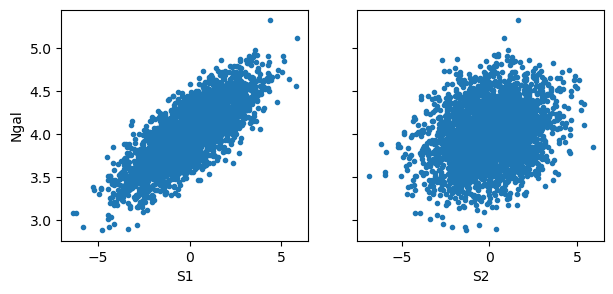

In [3]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
ax[0].plot(S1,N,'.');ax[1].plot(S2,N,'.')
ax[0].set_xlabel('S1'); ax[1].set_xlabel('S2'); ax[0].set_ylabel('Ngal');

In [4]:
#define some functions 

def binned_density(x,y,weights=None, nbins=10):
    if weights is None:
        weights = np.ones(len(y))
    edges = np.linspace(x.min(),x.max(),nbins+1)
    area_sbins,_   = np.histogram(x,edges) #number of pixels in each sbin
    counts_sbins,_ = np.histogram(x,edges,weights=y*weights) #sum of the number counts in sbin
    yout = counts_sbins/area_sbins
    ytotal = sum(y)/len(x)
    xout = (edges[1:]+edges[:-1])/2.
    return xout,yout/ytotal

def compute_linear_weights(S,N1,weights=None,nbins=10):
    x,y = binned_density(S,N1,weights=weights,nbins=nbins)
    p = np.polyfit(x,y,1)
    f = np.polyval(p,S)
    w = 1/f
    return w

On the real data, we usually plot this as a binned average number denisty vs SP:

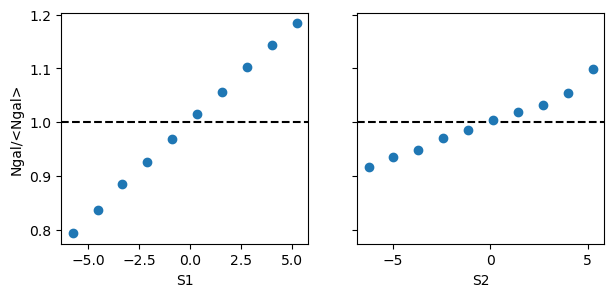

In [5]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x1,y1 = binned_density(S1,N)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o')

x2,y2 = binned_density(S2,N)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[0].set_xlabel('S1'); ax[1].set_xlabel('S2'); ax[0].set_ylabel('Ngal/<Ngal>');

# Correct for S1

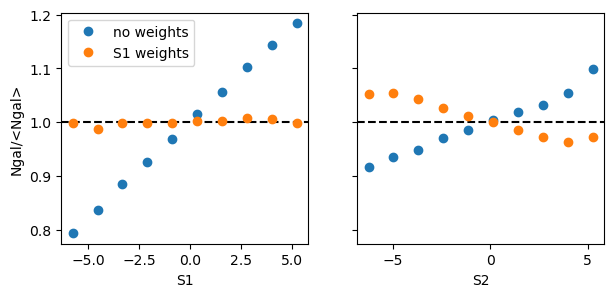

In [6]:
w1 = compute_linear_weights(S1,N)

fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x11,y11 = binned_density(S1,N,w1)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o',label='no weights')
ax[0].plot(x11,y11,'o',label='S1 weights')
ax[0].legend()

x21,y21 = binned_density(S2,N,w1)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[1].plot(x21,y21,'o')
ax[0].set_xlabel('S1'); ax[1].set_xlabel('S2'); ax[0].set_ylabel('Ngal/<Ngal>');

Note how correcting for S1 has changed the correlation with S2
The new trend with S2 depends on which components N is correlated with

Remember in this case:

S1 = A+B+C

S2 = A+B+D

N1 = Nmean + alpha*A + gamma*C

gamma introduces the difference between the N vs S1 correlation and the N vs S2 

If gamma was 0, the correlation with s1 and s2 would be the same 

I *think* the larger gamma is, the stronger the anti-correlation with S2 will be after correcting

### Quickly Show Setting gamma = 0

Text(0.5, 1.0, 'GAMMA=0')

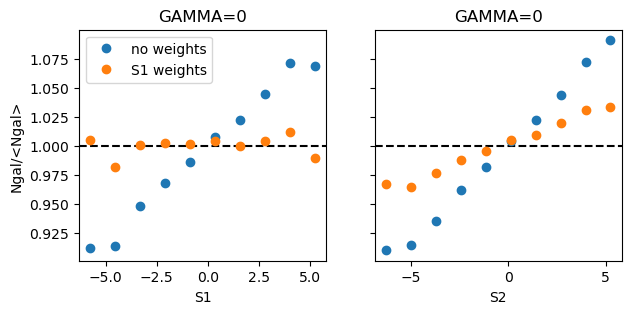

In [7]:
alpha = 0.2
beta  = 0.0
gamma = 0.0 
delta = 0.0
Nmean = 4 #mean number of galaxies per pixel (just to make it positive)
N_g0 = Nmean+alpha*A + beta*B + gamma*C + delta*D

w1_g0 = compute_linear_weights(S1,N_g0)

fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x1_g0,y1_g0 = binned_density(S1,N_g0)
x11_g0,y11_g0 = binned_density(S1,N_g0,w1_g0)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1_g0,y1_g0,'o',label='no weights')
ax[0].plot(x11_g0,y11_g0,'o',label='S1 weights')
ax[0].legend();ax[0].set_title('GAMMA=0')

x2_g0,y2_g0 = binned_density(S2,N_g0)
x21_g0,y21_g0 = binned_density(S2,N_g0,w1_g0)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2_g0,y2_g0,'o')
ax[1].plot(x21_g0,y21_g0,'o')
ax[0].set_xlabel('S1'); ax[1].set_xlabel('S2'); ax[0].set_ylabel('Ngal/<Ngal>');
ax[1].set_title('GAMMA=0')

Here we see when gamma=0, the S1 weights help somewhat to mitigate the S2 correlation, but not fully

### Back to the Original gamma != 0 example

### Iteration step=2

Next step is to apply a second iteration of weights correcting for the residual S2 correlation

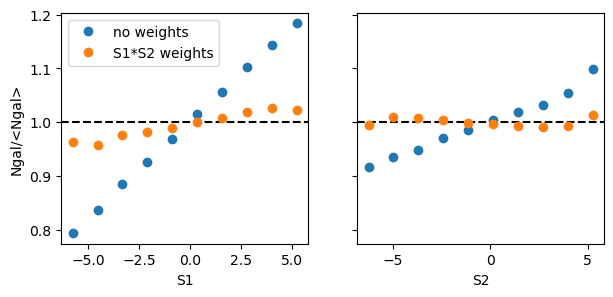

In [8]:
#S2 weights from the *S1 weighted* sample
w2 = compute_linear_weights(S2,N,w1)

w12 = w1*w2

fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x12,y12 = binned_density(S1,N,w12)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o',label='no weights')
ax[0].plot(x12,y12,'o',label='S1*S2 weights')
ax[0].legend()

x22,y22 = binned_density(S2,N,w12)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[1].plot(x22,y22,'o')
ax[0].set_xlabel('S1'); ax[1].set_xlabel('S2'); ax[0].set_ylabel('Ngal/<Ngal>');



Now we see the S2 correlation is 0 but this has induced a small correlation to S1

If we were to repeat this iterative process, the induced correlations get smaller and smaller. The process converges when all the 1d correlations are below some threshold

For our example a third iteration should do this


### Iteration step=3

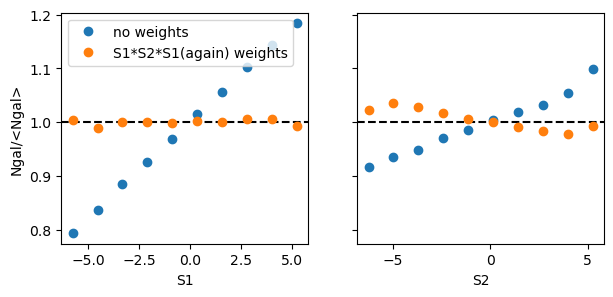

In [9]:
w3 = compute_linear_weights(S1,N,w12)

w123 = w1*w2*w3

fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x13,y13 = binned_density(S1,N,w123)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o',label='no weights')
ax[0].plot(x13,y13,'o',label='S1*S2*S1(again) weights')
ax[0].legend()

x23,y23 = binned_density(S2,N,w123)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[1].plot(x23,y23,'o')
ax[0].set_xlabel('S1'); ax[1].set_xlabel('S2'); ax[0].set_ylabel('Ngal/<Ngal>');


Success!

Though this method has its flaws.... FOr example, you can end up see-sawing between maps and the process will never(?) converge. Too many regression steps could introduce noise or possibly an overcorrection bias (because the real data has clustering)

It would be nicer if the SP maps were not correlated. That way we could guarantee we need at most Nmaps regressions (and ideally fewer)

# PCA maps

We can do a principle component analysis of the SP maps to get uncorrelated maps

These PCA maps will each be a linear combination of the SP maps, with coefficients such that they are orthogonal

The first principle component is the direction in SP vs SP space with the largest variance

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

data = np.array([S1,S2])
pca.fit(data.T)

#components of the PCA (the coefficients)
comp0 = pca.components_[0]
comp1 = pca.components_[1]

#The PCA maps 
PC0 = comp0[0]*S1+comp0[1]*S2
PC1 = comp1[0]*S1+comp1[1]*S2


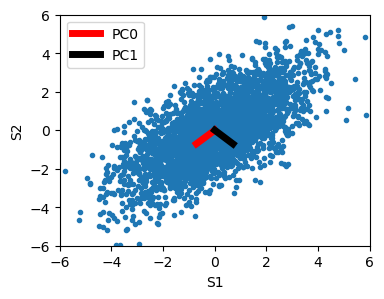

In [11]:
fig,ax = plt.subplots(1,1,sharey=True, figsize=(4,3))
ax.plot(S1,S2,'.')
ax.plot([0,comp0[0]],[0,comp0[1]], lw=5, color='r', label='PC0')
ax.plot([0,comp1[0]],[0,comp1[1]], lw=5, color='k', label='PC1')
ax.set_xlabel('S1'); ax.set_ylabel('S2'); ax.legend()
ax.set_xlim([-6,6]);ax.set_ylim([-6,6]);

Black and red lines are the directions in (S1, S2) space we use for the two PCA components

They *should* be at right angle to each other, I'm guessing any deviation from this comes from noise in the distributions?

Text(0, 0.5, 'PC1')

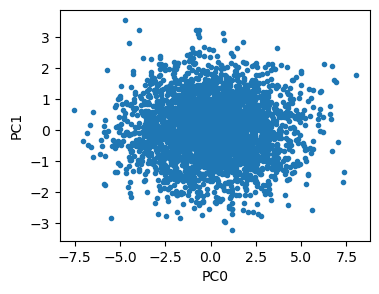

In [12]:
fig,ax = plt.subplots(1,1,sharey=True, figsize=(4,3))
ax.plot(PC0,PC1,'.')
ax.set_xlabel('PC0'); ax.set_ylabel('PC1')

PC0 and PC1 dont look correlated, this is good

## Correct using PCA maps

Now we can do the same correction procedure as before but using the PCA maps instead of the SP maps

### no weights

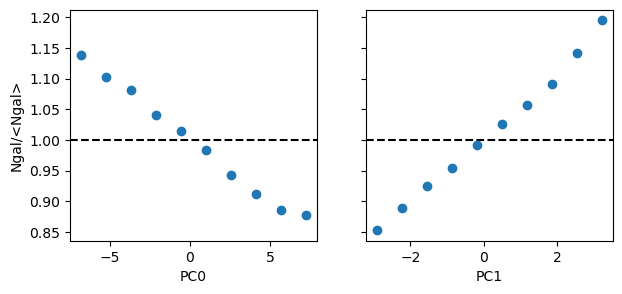

In [13]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x1,y1 = binned_density(PC0,N)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o')

x2,y2 = binned_density(PC1,N)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[0].set_xlabel('PC0'); ax[1].set_xlabel('PC1'); ax[0].set_ylabel('Ngal/<Ngal>');

### iteration=1 PC0 weights

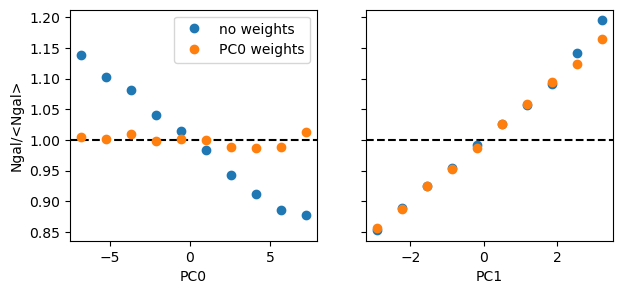

In [14]:
w1 = compute_linear_weights(PC0,N)

fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x11,y11 = binned_density(PC0,N,w1)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o',label='no weights')
ax[0].plot(x11,y11,'o',label='PC0 weights')
ax[0].legend()

x21,y21 = binned_density(PC1,N,w1)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[1].plot(x21,y21,'o')
ax[0].set_xlabel('PC0'); ax[1].set_xlabel('PC1'); ax[0].set_ylabel('Ngal/<Ngal>');

see how the PC1 correlation now does not change

### iteration=2 PC0 and PC1 weights

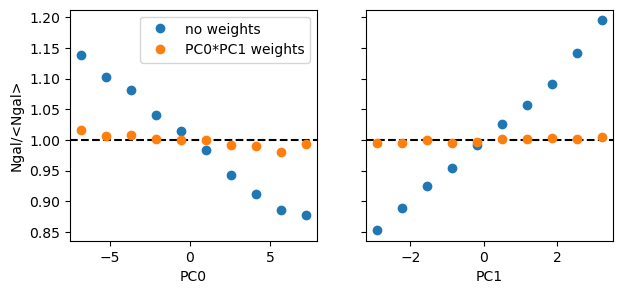

In [15]:
#PC1 weights from the *PC0 weighted* sample
w2 = compute_linear_weights(PC1,N,w1)

w12 = w1*w2

fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x12,y12 = binned_density(PC0,N,w12)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o',label='no weights')
ax[0].plot(x12,y12,'o',label='PC0*PC1 weights')
ax[0].legend()

x22,y22 = binned_density(PC1,N,w12)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[1].plot(x22,y22,'o')
ax[0].set_xlabel('PC0'); ax[1].set_xlabel('PC1'); ax[0].set_ylabel('Ngal/<Ngal>');


Success!!

## SP correlations with PCA weights

Now...as a test lets look at the SP map correlations using the PCA weights!

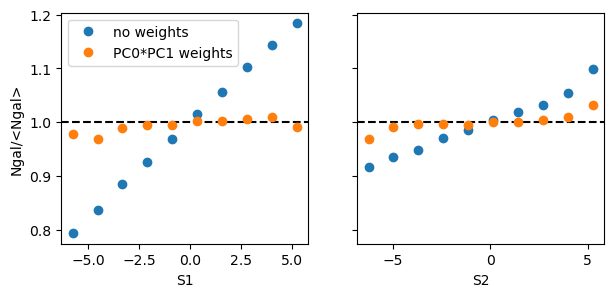

In [16]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x1,y1 = binned_density(S1,N)
x12,y12 = binned_density(S1,N,w12)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o',label='no weights')
ax[0].plot(x12,y12,'o',label='PC0*PC1 weights')
ax[0].legend()

x2,y2 = binned_density(S2,N)
x22,y22 = binned_density(S2,N,w12)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[1].plot(x22,y22,'o')
ax[0].set_xlabel('S1'); ax[1].set_xlabel('S2'); ax[0].set_ylabel('Ngal/<Ngal>');

So it works!!! correcting for the PCA map correlation fixed the SP map correlations. and we are guaranteed to have no see-saws, or repeat corrections

## Computing weights on a patch of sky using full sky PCAs

Lets imagine we are now studying only half the data, and the SP properties in this half are not neccesarily representative of the full sky

We are no longer guaranteed to have orthogonal PCA maps

An example...

The orange band will be our patch of sky 

Text(0, 0.5, 'PC1')

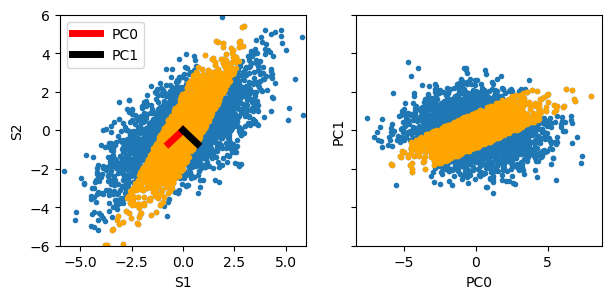

In [17]:
select = (S2 < 2*S1+2)*(S2 > 2*S1-2)

fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
ax[0].plot(S1,S2,'.')
ax[0].plot(S1[select],S2[select],'.',color='orange')
ax[0].plot([0,comp0[0]],[0,comp0[1]], lw=5, color='r', label='PC0')
ax[0].plot([0,comp1[0]],[0,comp1[1]], lw=5, color='k', label='PC1')
ax[0].set_xlabel('S1'); ax[0].set_ylabel('S2'); ax[0].legend()
ax[0].set_xlim([-6,6]);ax[0].set_ylim([-6,6]);

ax[1].plot(PC0,PC1,'.')
ax[1].plot(PC0[select],PC1[select],'.',color='orange')
ax[1].set_xlabel('PC0'); ax[1].set_ylabel('PC1')

S1 and S2 are still correlated but now PC0 and PC1 are too!

### sub-patch: No weights

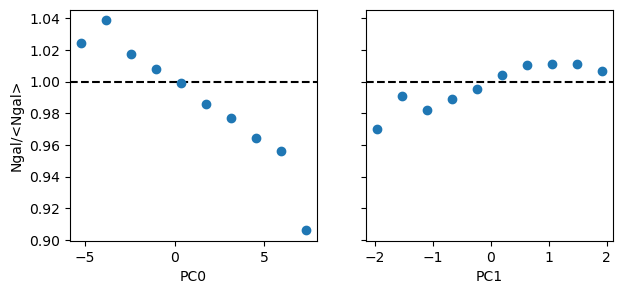

In [18]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x1,y1 = binned_density(PC0[select],N[select])
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o')

x2,y2 = binned_density(PC1[select],N[select])
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[0].set_xlabel('PC0'); ax[1].set_xlabel('PC1'); ax[0].set_ylabel('Ngal/<Ngal>');

### sub-patch: iteration=1 PC0 weights

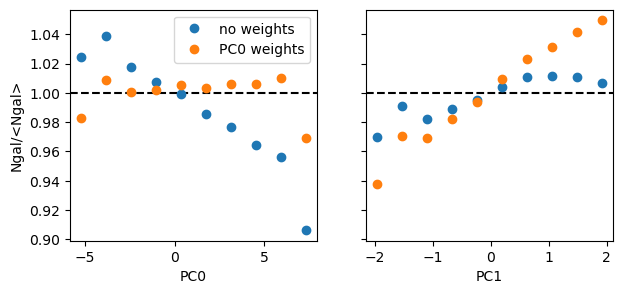

In [19]:
w1 = compute_linear_weights(PC0[select],N[select])

fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x11,y11 = binned_density(PC0[select],N[select],w1)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o',label='no weights')
ax[0].plot(x11,y11,'o',label='PC0 weights')
ax[0].legend()

x21,y21 = binned_density(PC1[select],N[select],w1)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[1].plot(x21,y21,'o')
ax[0].set_xlabel('PC0'); ax[1].set_xlabel('PC1'); ax[0].set_ylabel('Ngal/<Ngal>');

Correcting for PC0 now *does* change the PC1 correlation - bad sign

### sub-patch: iteration=2 PC1 and PC0 weights

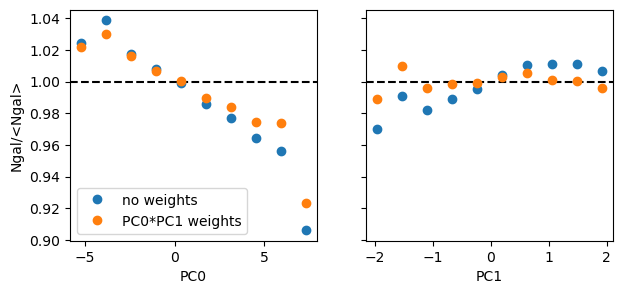

In [20]:
#PC1 weights from the *PC0 weighted* sample
w2 = compute_linear_weights(PC1[select],N[select],w1)

w12 = w1*w2

fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x12,y12 = binned_density(PC0[select],N[select],w12)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o',label='no weights')
ax[0].plot(x12,y12,'o',label='PC0*PC1 weights')
ax[0].legend()

x22,y22 = binned_density(PC1[select],N[select],w12)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[1].plot(x22,y22,'o')
ax[0].set_xlabel('PC0'); ax[1].set_xlabel('PC1'); ax[0].set_ylabel('Ngal/<Ngal>');

Oh no! Correcting for PC1 has induced a large PC0 correlation

### sub-patch: N-iterations

Use this to input some number of iterations to run 

We will alternate between the two PC MAPS, but ideally the choice of map would be based on the size of the correlation

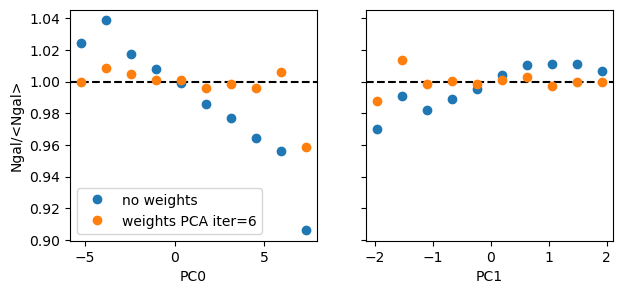

In [35]:
niterations = 4
wtotal = np.ones(len(N[select]))
PCMAPS = [PC0,PC1]
for i_iter in range(niterations):
    SMAP = PCMAPS[i_iter%2]
    w_iter = compute_linear_weights(SMAP[select],N[select],wtotal)
    wtotal *= w_iter

fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))

x1,y1 = binned_density(PC0[select],N[select])
x12,y12 = binned_density(PC0[select],N[select],wtotal)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o',label='no weights')
ax[0].plot(x12,y12,'o',label='weights PCA iter={0}'.format(niterations))
ax[0].legend()

x2,y2 = binned_density(PC1[select],N[select])
x22,y22 = binned_density(PC1[select],N[select],wtotal)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[1].plot(x22,y22,'o')
ax[0].set_xlabel('PC0'); ax[1].set_xlabel('PC1'); ax[0].set_ylabel('Ngal/<Ngal>');

### sub-patch: SP correlations with PC weights

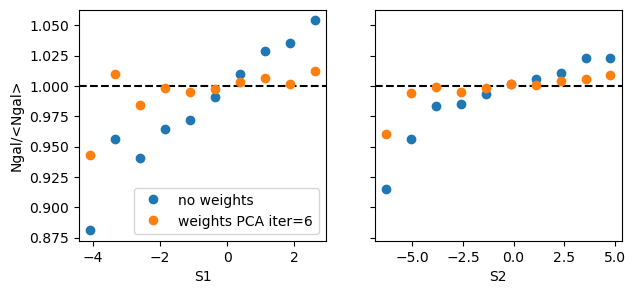

In [36]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=(7,3))
x1,y1 = binned_density(S1[select],N[select])
x12,y12 = binned_density(S1[select],N[select],wtotal)
ax[0].axhline(1.0,color='k',ls='--')
ax[0].plot(x1,y1,'o',label='no weights')
ax[0].plot(x12,y12,'o',label='weights PCA iter={0}'.format(niterations))
ax[0].legend()

x2,y2 = binned_density(S2[select],N[select])
x22,y22 = binned_density(S2[select],N[select],wtotal)
ax[1].axhline(1.0,color='k',ls='--')
ax[1].plot(x2,y2,'o')
ax[1].plot(x22,y22,'o')
ax[0].set_xlabel('S1'); ax[1].set_xlabel('S2'); ax[0].set_ylabel('Ngal/<Ngal>');